In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df1 = pd.read_csv('./data/GPP_NEE_flux_2001-2022.csv')
df2 = pd.read_csv('./data/voc_2010-2022.csv')
df3 = pd.read_csv('./data/latent_heat_flux_2018-2022.csv')
df4 = pd.read_csv('./data/latent_heat_flux_2001-2018.csv')
df5 = pd.read_csv('./data/sensible_heat_flux_2001-2022.csv')

# Drop columnns 'Unnamed: 0'
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df3 = df3.drop(columns=['Unnamed: 0'])
df4 = df4.drop(columns=['Unnamed: 0'])
df5 = df5.drop(columns=['Unnamed: 0'])

# Convert time labels to datetime objects
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df3['Datetime'] = pd.to_datetime(df3['Datetime'])
df4['Datetime'] = pd.to_datetime(df4['Datetime'])
df5['Datetime'] = pd.to_datetime(df5['Datetime'])

In [3]:
# 1) Select the aggregation method. Allowed values are 'mean' or 'median'
# agg_method = 'mean'
agg_method = 'median'
assert agg_method in ['mean', 'median']

# 2) Select the measurement hours to consider. Allowed values are 'all', 'noon'
# daily_hours = 'all'
daily_hours = 'noon'
assert daily_hours in ['all', 'noon']

In [4]:
if daily_hours=='noon':   
    # keep only observations occurring during 10.00-14.00 each day
    df1 = df1[(df1['Datetime'].dt.hour>=10) & (df1['Datetime'].dt.hour<=14)]
    df2 = df2[(df2['Datetime'].dt.hour>=10) & (df2['Datetime'].dt.hour<=14)]
    df3 = df3[(df3['Datetime'].dt.hour>=10) & (df3['Datetime'].dt.hour<=14)]
    df4 = df4[(df4['Datetime'].dt.hour>=10) & (df4['Datetime'].dt.hour<=14)]
    df5 = df5[(df5['Datetime'].dt.hour>=10) & (df5['Datetime'].dt.hour<=14)]

In [5]:
# Keep only the rows where NEE_gapfilling_method is 0
df1 = df1[df1.NEE_gapfilling_method == 0]

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [6]:
# Aggregate to daily level
if agg_method == 'mean':
    daily_df1 = df1.resample('D', on = 'Datetime').mean().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').mean().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').mean().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').mean().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').mean().reset_index()
elif agg_method == 'median':
    daily_df1 = df1.resample('D', on = 'Datetime').median().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').median().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').median().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').median().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').median().reset_index()
else:
    raise ValueError('agg_method must be either "mean" or "median"')

In [7]:
qdf = pd.DataFrame({'a': [201, 324, 124, 214, 112, 110, 152, 165, 241, 150]})
quantiles = qdf['a'].quantile([0.1, 0.9])
#print(quantiles)

l = sorted(qdf['a'])
#print(l)

# values outside the 0.1-0.9 quantile range
l = [x for x in l if x < quantiles[0.1] or x > quantiles[0.9]]
#print(l)
ddf1 = daily_df1[daily_df1['Datetime'].dt.year >= 2010]
ddf1.head()

ddf2 = daily_df2[daily_df2['Datetime'].dt.year >= 2010]
ddf2.head()

ddf3 = daily_df3[daily_df3['Datetime'].dt.year >= 2010]
ddf3.head()

ddf4 = daily_df4[daily_df4['Datetime'].dt.year >= 2010]
ddf4.head()

ddf4 = ddf4.rename(columns={'HYY_EDDY233.LE': 'lh_flux'})
ddf4 = ddf4.drop(columns=['HYY_EDDY233.Qc_LE'])

ddf3 = ddf3.rename(columns={'latent_heat_flux_after_4-2018': 'lh_flux'})
ddf3 = ddf3.drop(columns=['latent_heat_flux_quality_flag_after_4-2018'])
lh_df = pd.concat([ddf4, ddf3], ignore_index=True)

lh_df = lh_df[lh_df['Datetime'].dt.year >= 2010]
lh_df.head()

daily_df5.head()
#drop rows where datetime is before 2010-05-29
ddf5 = daily_df5[daily_df5['Datetime'].dt.year >= 2010]
ddf5.head()

#full_df = pd.concat([ddf1['Datetime'], ddf1['NEE']])
#full_df.head()
ddf1 = ddf1.drop(columns=['NEE_gapfilling_method', 'GPP'])
ddf5 = ddf5.drop(columns=['sensible_heat_flux_gapfilling_method'])

ddf = pd.merge(ddf1, ddf2, on='Datetime', how='inner')
ddf = pd.merge(ddf, lh_df, on='Datetime', how='inner')
ddf = pd.merge(ddf, ddf5, on='Datetime', how='inner')
ddf.head()


,Datetime,NEE,monoterpene_flux,methanol_flux,acetone_flux,acetaldehyde_flux,lh_flux,sensible_heat_flux
0,2010-05-29,-10.0310,10.613590,16.89274,7.57044,2.652575,54.65915,42.8565
1,2010-05-30,-11.4725,38.513825,34.04258,1.72830,3.922185,165.80755,174.5570
2,2010-05-31,-10.5330,54.609810,29.41079,5.05139,2.909770,194.49385,257.2225
3,2010-06-01,-9.4610,44.327820,44.19043,17.50203,NaN,170.20680,316.2715
4,2010-06-02,-8.9000,NaN,NaN,NaN,NaN,177.06070,365.3675


In [8]:
# set the window size
WINDOW_SIZE = 30

# Dictionary to help selecting data and labeling the plots
months = {1: 'January', 
          2: 'February', 
          3: 'March', 
          4: 'April', 
          5: 'May', 
          6: 'June', 
          7: 'July', 
          8: 'August', 
          9: 'September', 
          10: 'October', 
          11: 'November', 
          12: 'December'}

# select the months of interest
start_month = 5
end_month = 8

In [9]:
# Filter data for start_month and end_month
daily_df_med = ddf[(ddf['Datetime'].dt.month >= start_month) 
                            & (ddf['Datetime'].dt.month <= end_month)].copy()

# Calculate WINDOW_SIZE-day rolling median
daily_df_med['monoterp_rm'] = daily_df_med['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['methanol_rm'] = daily_df_med['methanol_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['acetone_rm'] = daily_df_med['acetone_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['acetaldehyde_rm'] = daily_df_med['acetaldehyde_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['sensible_heat_rm'] = daily_df_med['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['latent_heat_rm'] = daily_df_med['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1).median()
daily_df_med['nee_rm'] = daily_df_med['NEE'].rolling(window=WINDOW_SIZE, min_periods=1).median()

daily_df_med.drop(columns=['NEE', 'monoterpene_flux', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux', 'sensible_heat_flux', 'lh_flux'], inplace=True)
daily_df_med.head()

# make Datetime the index
daily_df_med.set_index('Datetime', inplace=True)

quant = daily_df_med.quantile([0.1, 0.9])
#print(quant)

def replace_values(col_name):
    lower_quantile = quant[col_name][0.1]
    upper_quantile = quant[col_name][0.9]
    return daily_df_med[col_name].apply(lambda x: 0 if (x >= lower_quantile and x <= upper_quantile) else 1)

# Apply the function to each column in the dataframe
for column in daily_df_med.columns:
    daily_df_med[column] = replace_values(column)

#daily_df_med.head()

daily_df_med['outliers'] = daily_df_med.sum(axis=1)

#hist = daily_df_med['outliers']

#daily_df_med['day'] = daily_df_med.index.dayofyear

daily_df_med_2010 = daily_df_med[daily_df_med.index.year == 2010]
daily_df_med_2011 = daily_df_med[daily_df_med.index.year == 2011]
daily_df_med_2012 = daily_df_med[daily_df_med.index.year == 2012]
daily_df_med_2013 = daily_df_med[daily_df_med.index.year == 2013]
daily_df_med_2014 = daily_df_med[daily_df_med.index.year == 2014]
daily_df_med_2015 = daily_df_med[daily_df_med.index.year == 2015]
daily_df_med_2016 = daily_df_med[daily_df_med.index.year == 2016]
daily_df_med_2017 = daily_df_med[daily_df_med.index.year == 2017]
daily_df_med_2018 = daily_df_med[daily_df_med.index.year == 2018]
daily_df_med_2019 = daily_df_med[daily_df_med.index.year == 2019]
daily_df_med_2020 = daily_df_med[daily_df_med.index.year == 2020]
daily_df_med_2021 = daily_df_med[daily_df_med.index.year == 2021]
daily_df_med_2022 = daily_df_med[daily_df_med.index.year == 2022]

#daily_df_med.head(50)

# new_df = pd.DataFrame({'day': daily_df_med['day'], 'outliers': daily_df_med['outliers']})


# new_df.set_index('day', inplace=True)

# new_df.plot(kind='bar', legend=False, figsize=(20, 8))
# plt.title('Histogram with of number of outliers')
# plt.xlabel('Day of year')
# plt.ylabel('Number of outliers')
# plt.show()

# # take the index column and convert it to a datetime object
# hist.index = pd.to_datetime(hist.index)

# # take only the indexes where year is 2010
# hist = hist[hist.index.year == 2010]

# hist['day'] = hist.index.dayofyear

# hist.set_index('day', inplace=True)

# hist.plot(kind='bar', legend=False, figsize=(20, 8))

# plt.title('Histogram with Dates as Bins')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.show()

/tmp/ipykernel_515689/124547797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2010['day'] = daily_df_med_2010.index.dayofyear


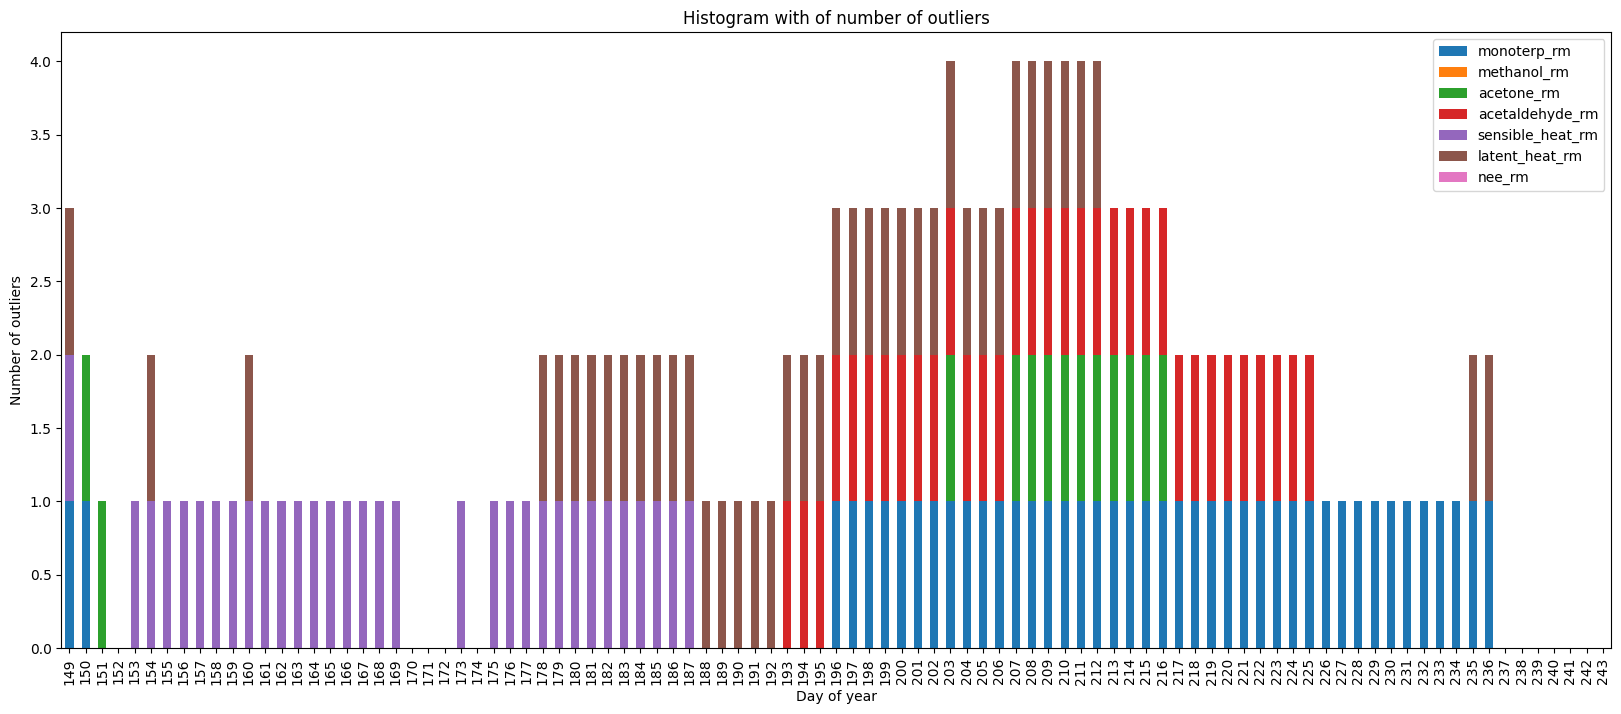

In [10]:
daily_df_med_2010['day'] = daily_df_med_2010.index.dayofyear

df_2010 = daily_df_med_2010.drop(columns=['outliers'])

df_2010.set_index('day', inplace=True)

df_2010.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/2145408108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2011['day'] = daily_df_med_2011.index.dayofyear


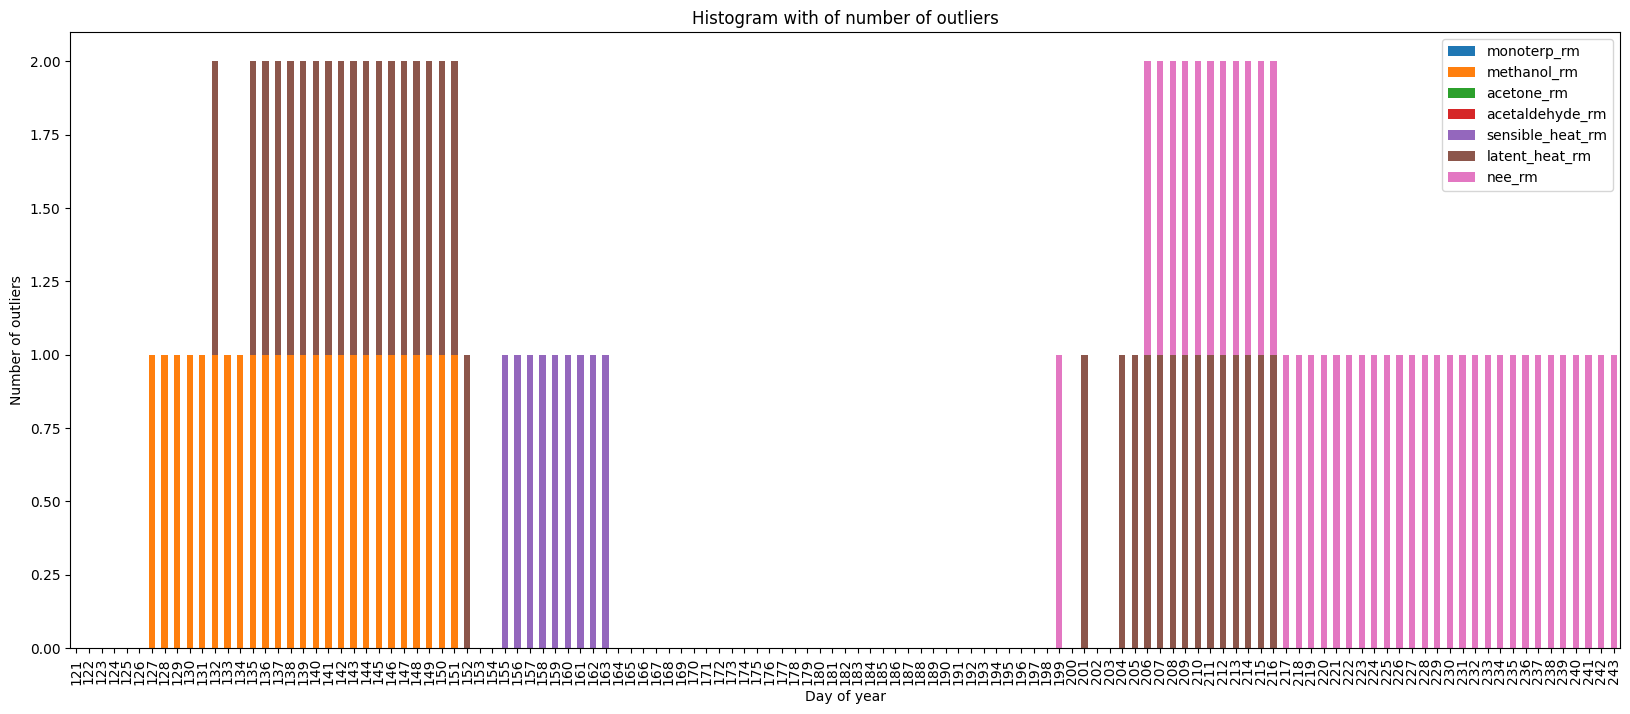

In [11]:
daily_df_med_2011['day'] = daily_df_med_2011.index.dayofyear

df_2011 = daily_df_med_2011.drop(columns=['outliers'])

df_2011.set_index('day', inplace=True)

df_2011.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/3962714831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2012['day'] = daily_df_med_2012.index.dayofyear


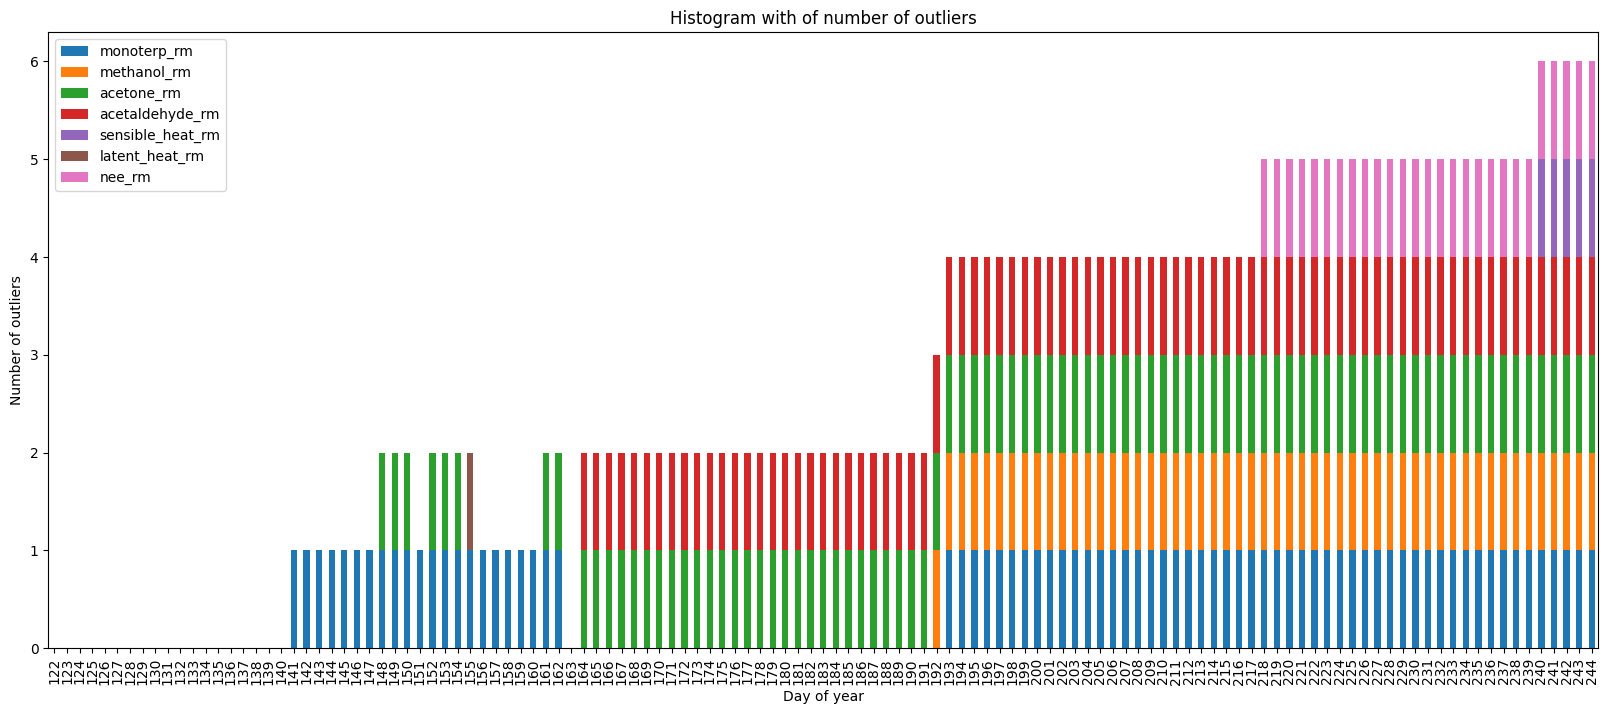

In [12]:
daily_df_med_2012['day'] = daily_df_med_2012.index.dayofyear

df_2012 = daily_df_med_2012.drop(columns=['outliers'])

df_2012.set_index('day', inplace=True)

df_2012.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/3211316318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2013['day'] = daily_df_med_2013.index.dayofyear


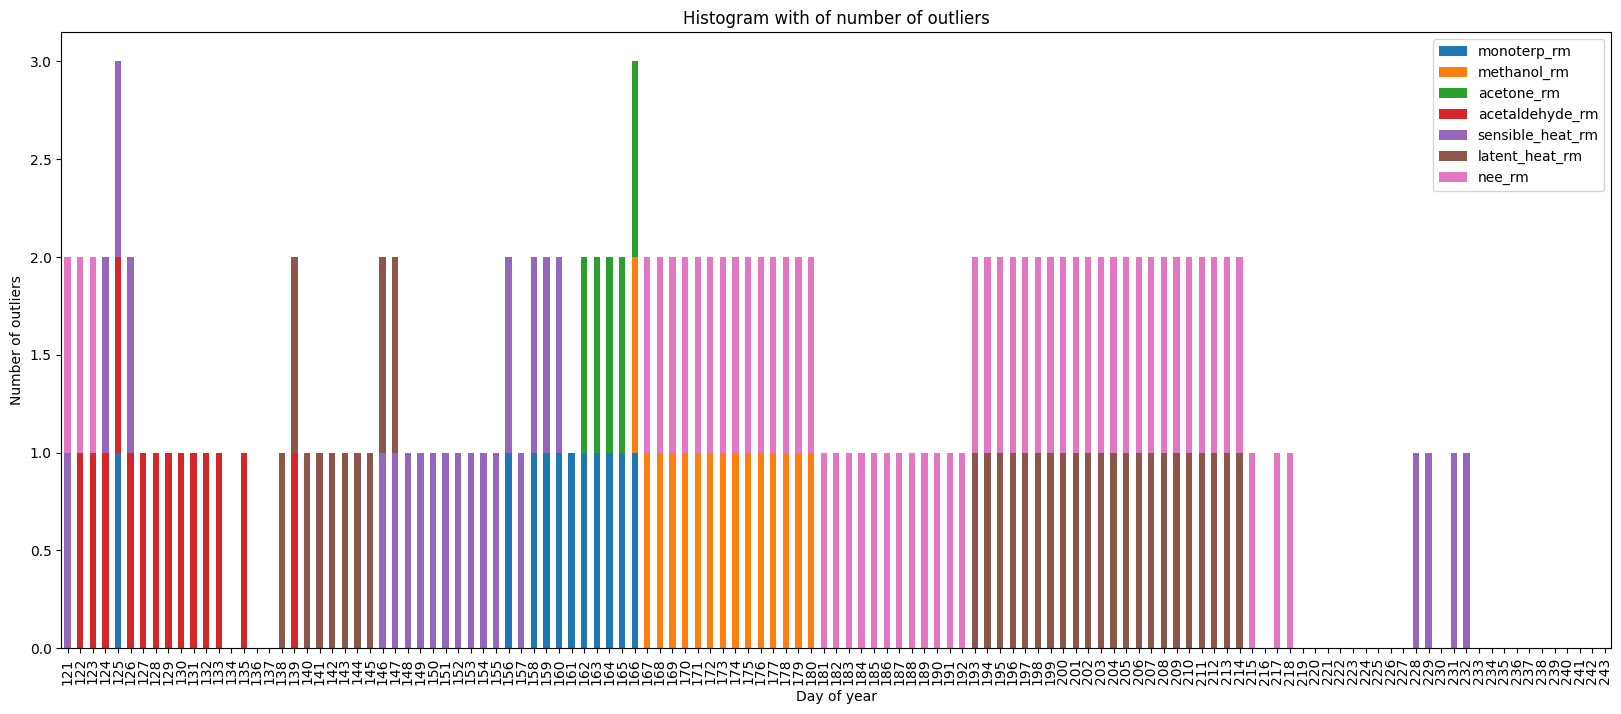

In [13]:
daily_df_med_2013['day'] = daily_df_med_2013.index.dayofyear

df_2013 = daily_df_med_2013.drop(columns=['outliers'])

df_2013.set_index('day', inplace=True)

df_2013.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/1370913272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2014['day'] = daily_df_med_2014.index.dayofyear


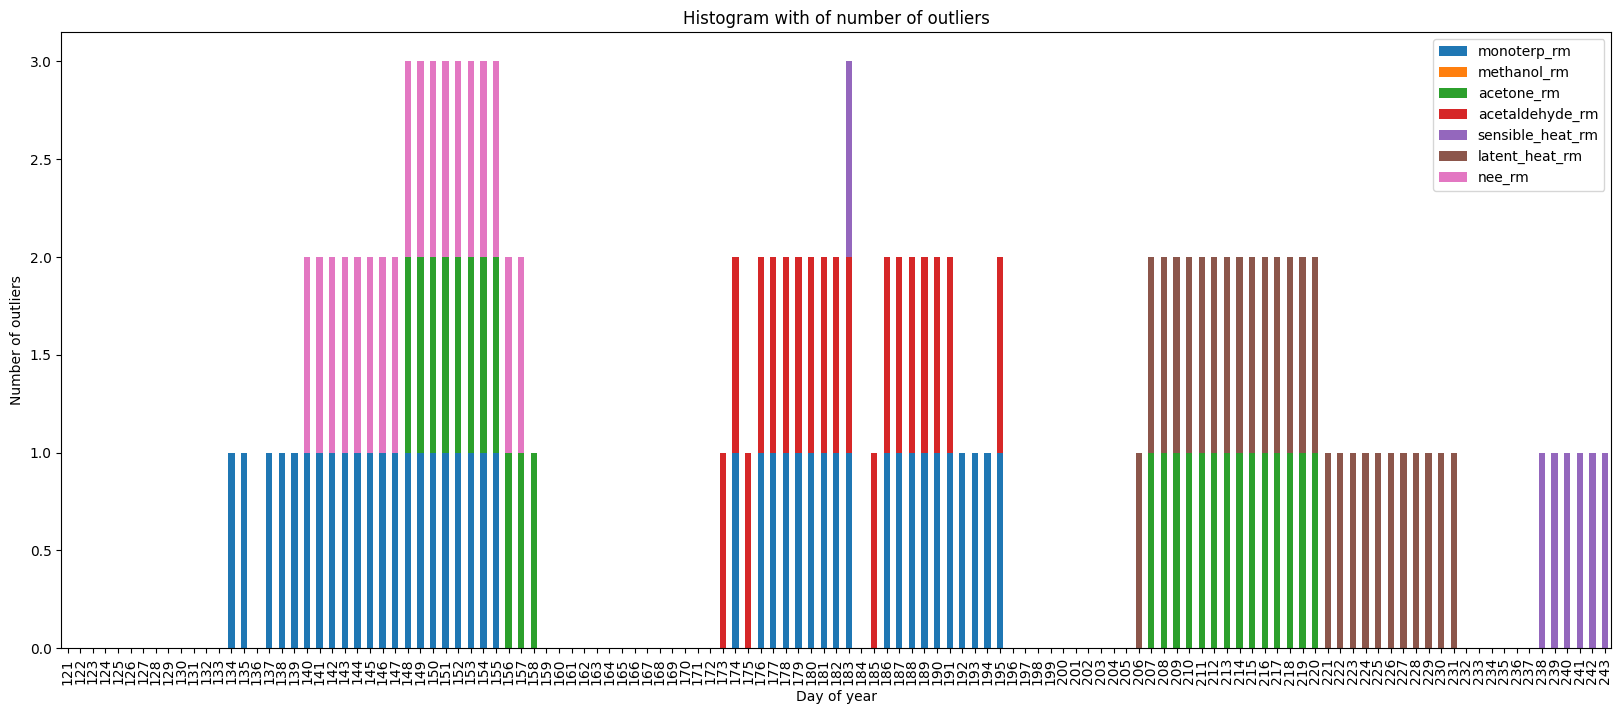

In [14]:
daily_df_med_2014['day'] = daily_df_med_2014.index.dayofyear

df_2014 = daily_df_med_2014.drop(columns=['outliers'])

df_2014.set_index('day', inplace=True)

df_2014.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/657290504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2015['day'] = daily_df_med_2015.index.dayofyear


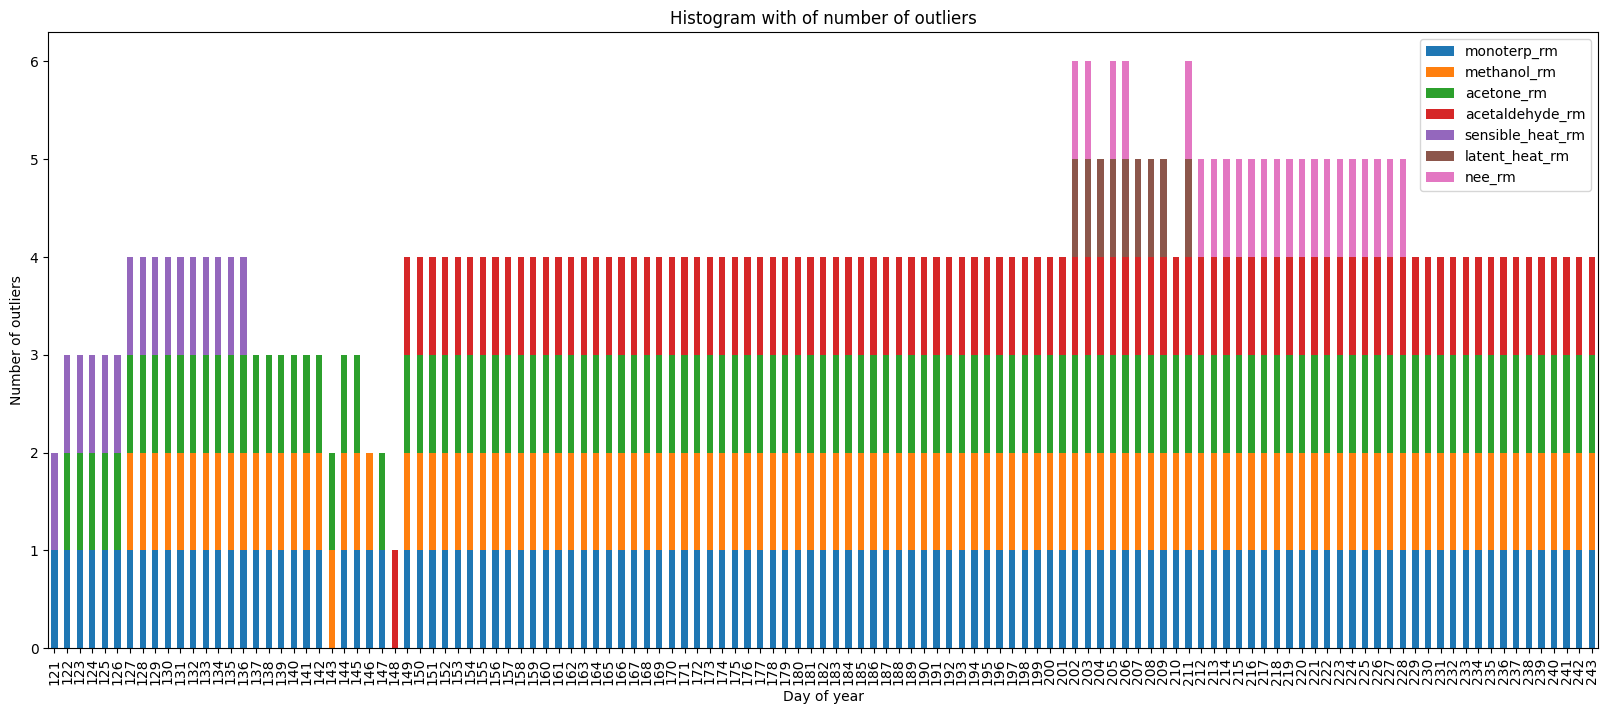

In [15]:
daily_df_med_2015['day'] = daily_df_med_2015.index.dayofyear

df_2015 = daily_df_med_2015.drop(columns=['outliers'])

df_2015.set_index('day', inplace=True)

df_2015.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/1589184935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2016['day'] = daily_df_med_2016.index.dayofyear


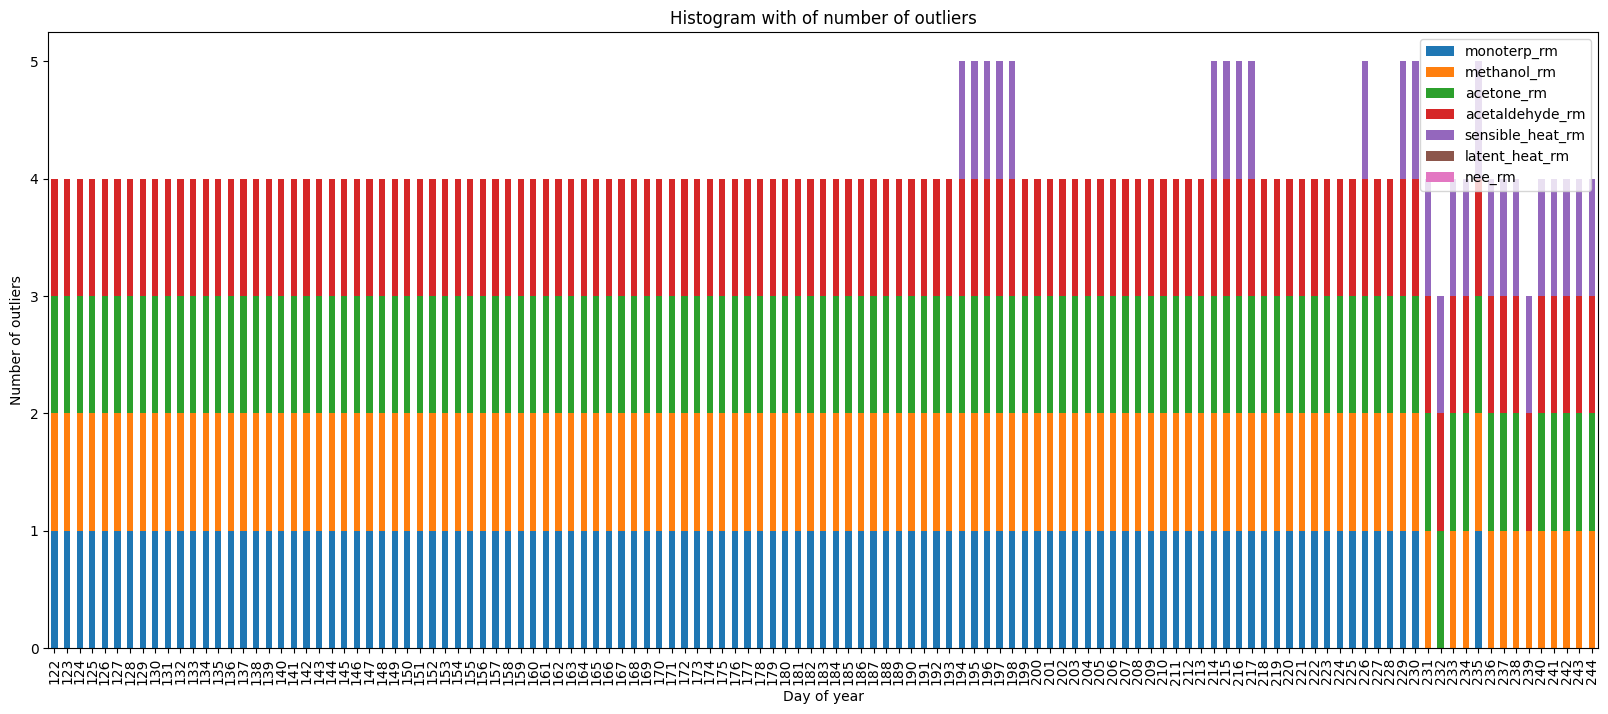

In [16]:
daily_df_med_2016['day'] = daily_df_med_2016.index.dayofyear

df_2016 = daily_df_med_2016.drop(columns=['outliers'])

df_2016.set_index('day', inplace=True)

df_2016.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/4119277257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2017['day'] = daily_df_med_2017.index.dayofyear


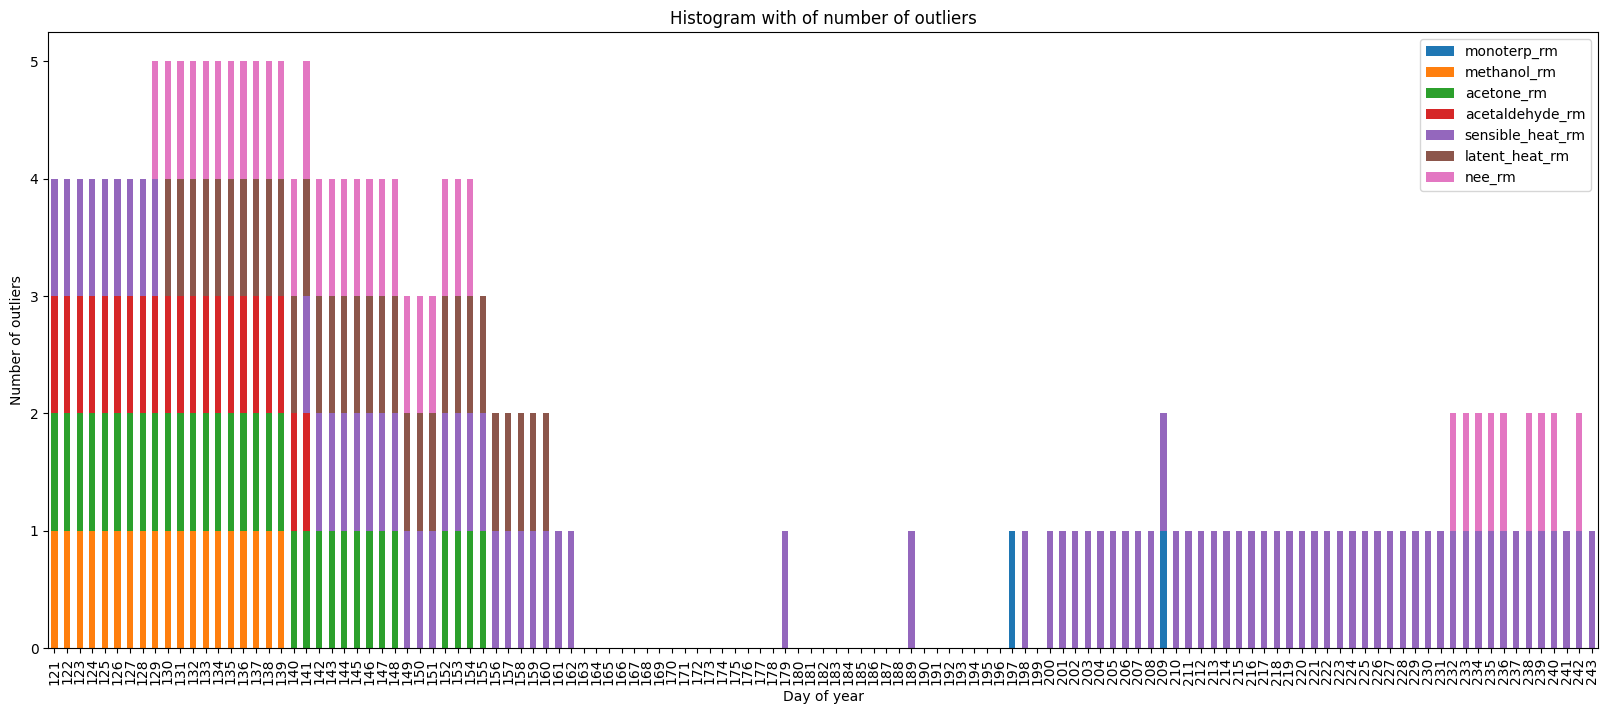

In [17]:
daily_df_med_2017['day'] = daily_df_med_2017.index.dayofyear

df_2017 = daily_df_med_2017.drop(columns=['outliers'])

df_2017.set_index('day', inplace=True)

df_2017.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/1487986071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2018['day'] = daily_df_med_2018.index.dayofyear


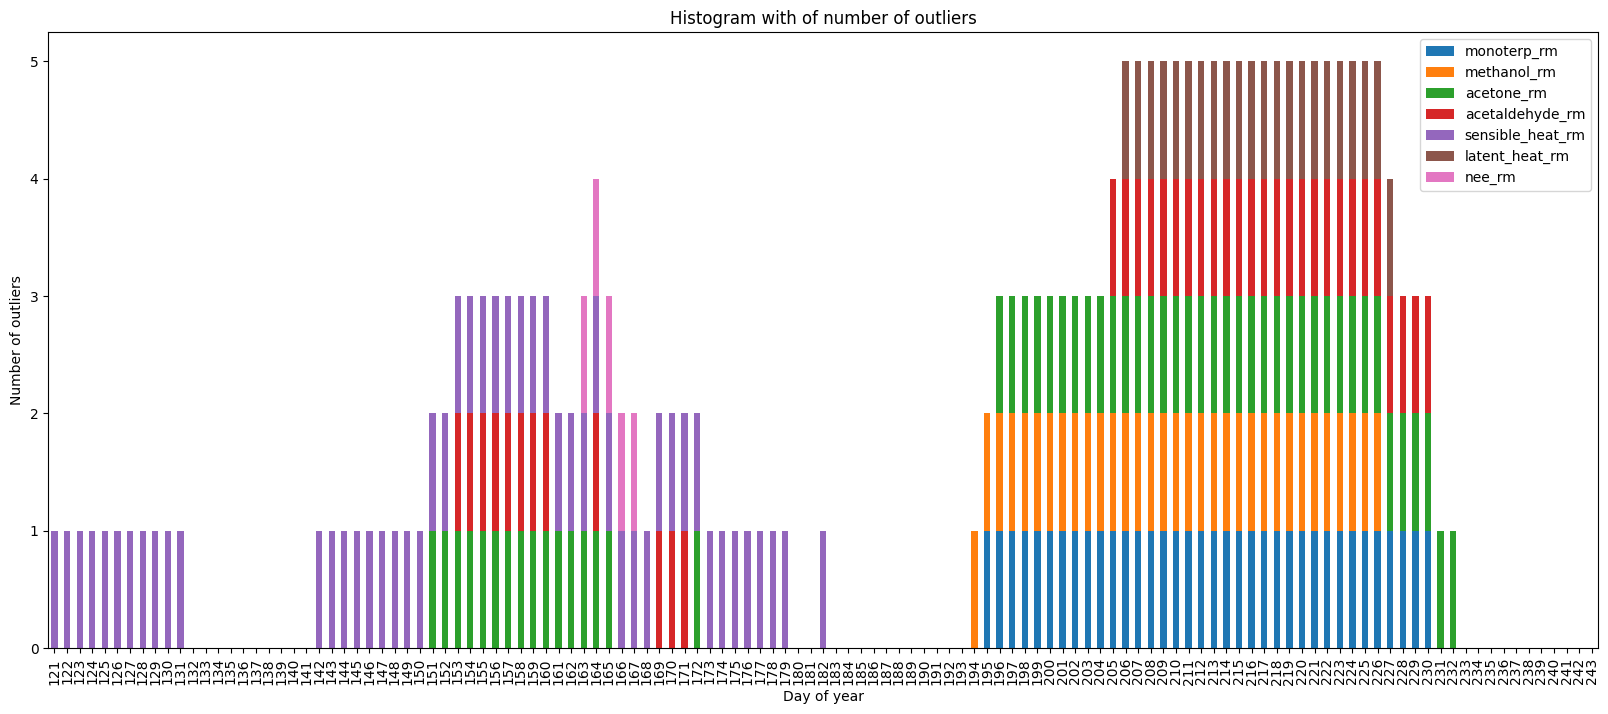

In [18]:
daily_df_med_2018['day'] = daily_df_med_2018.index.dayofyear

df_2018 = daily_df_med_2018.drop(columns=['outliers'])

df_2018.set_index('day', inplace=True)

df_2018.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/2314448366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2019['day'] = daily_df_med_2019.index.dayofyear


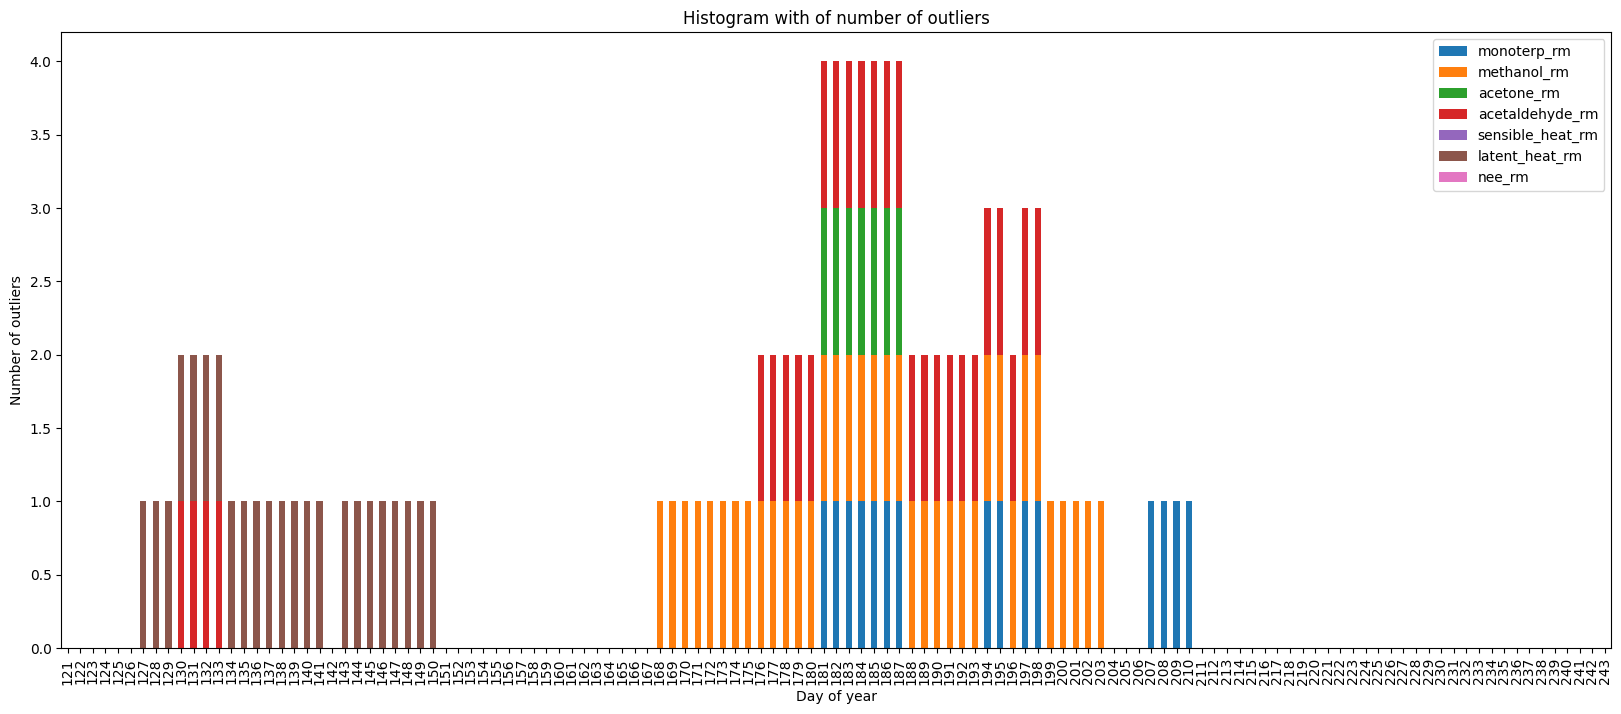

In [19]:
daily_df_med_2019['day'] = daily_df_med_2019.index.dayofyear

df_2019 = daily_df_med_2019.drop(columns=['outliers'])

df_2019.set_index('day', inplace=True)

df_2019.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_515689/1354058986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2020['day'] = daily_df_med_2020.index.dayofyear


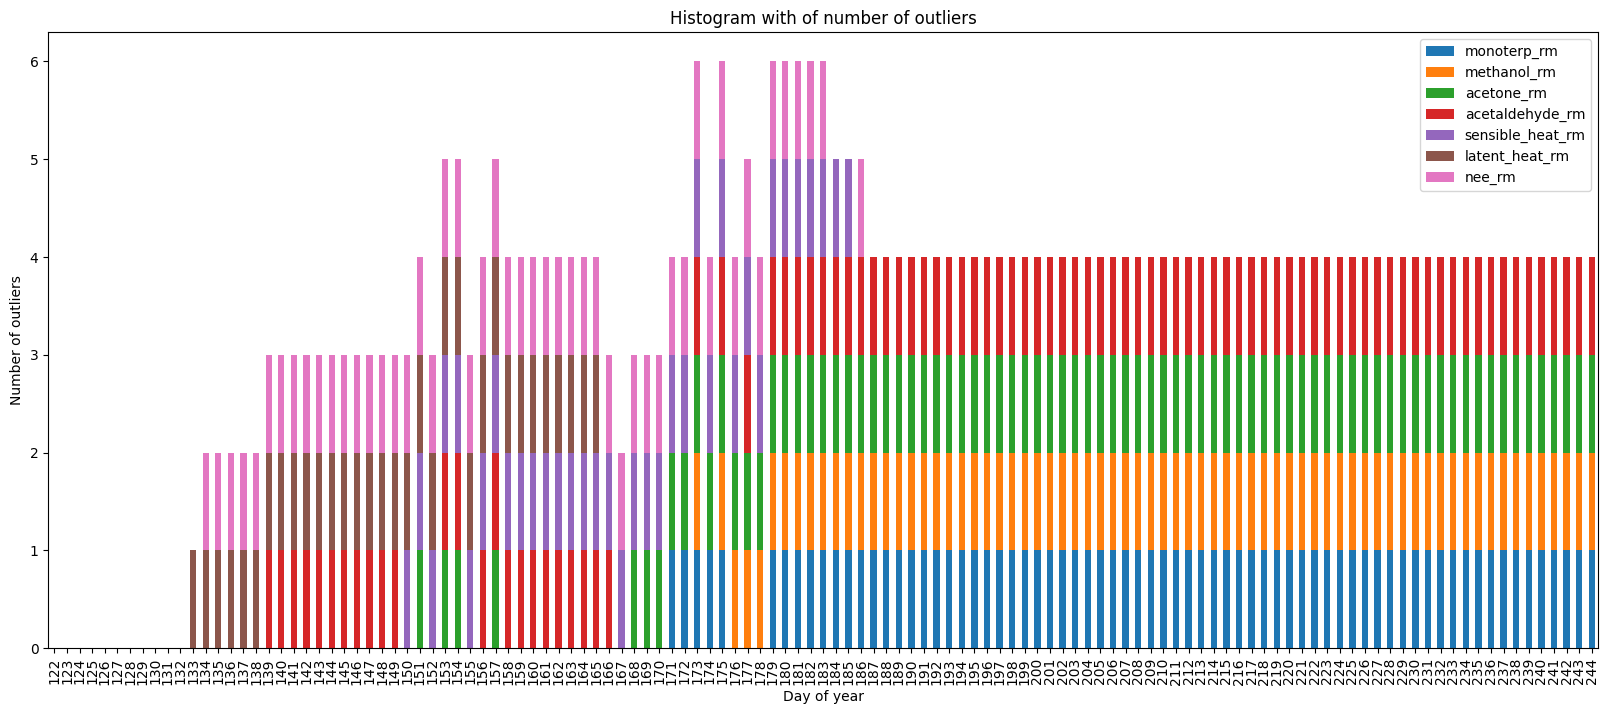

In [21]:
daily_df_med_2020['day'] = daily_df_med_2020.index.dayofyear

df_2020 = daily_df_med_2020.drop(columns=['outliers'])

df_2020.set_index('day', inplace=True)

df_2020.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_509611/3607311469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2021['day'] = daily_df_med_2021.index.dayofyear


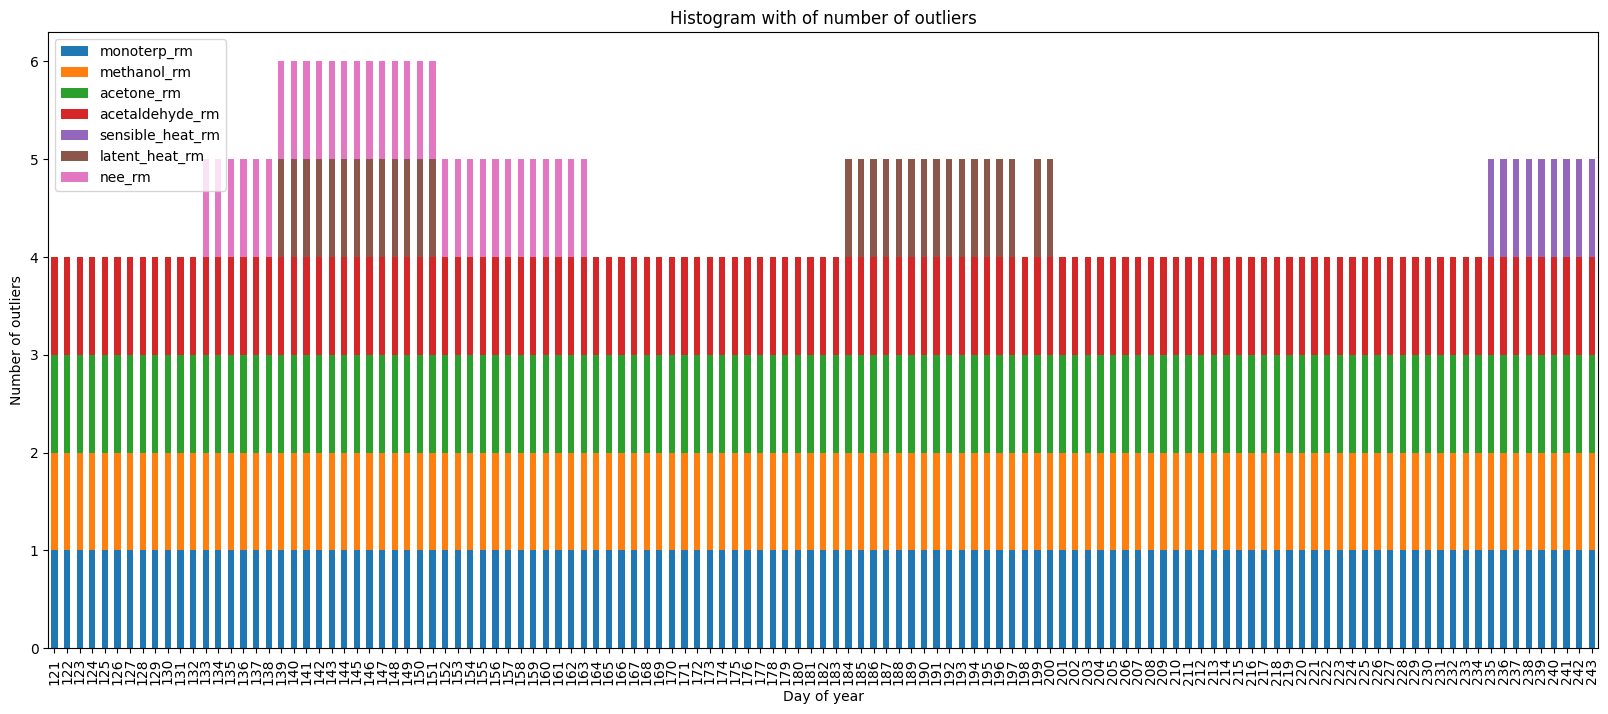

In [ ]:
daily_df_med_2021['day'] = daily_df_med_2021.index.dayofyear

df_2021 = daily_df_med_2021.drop(columns=['outliers'])

df_2021.set_index('day', inplace=True)

df_2021.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()


/tmp/ipykernel_509611/3067941220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df_med_2022['day'] = daily_df_med_2022.index.dayofyear


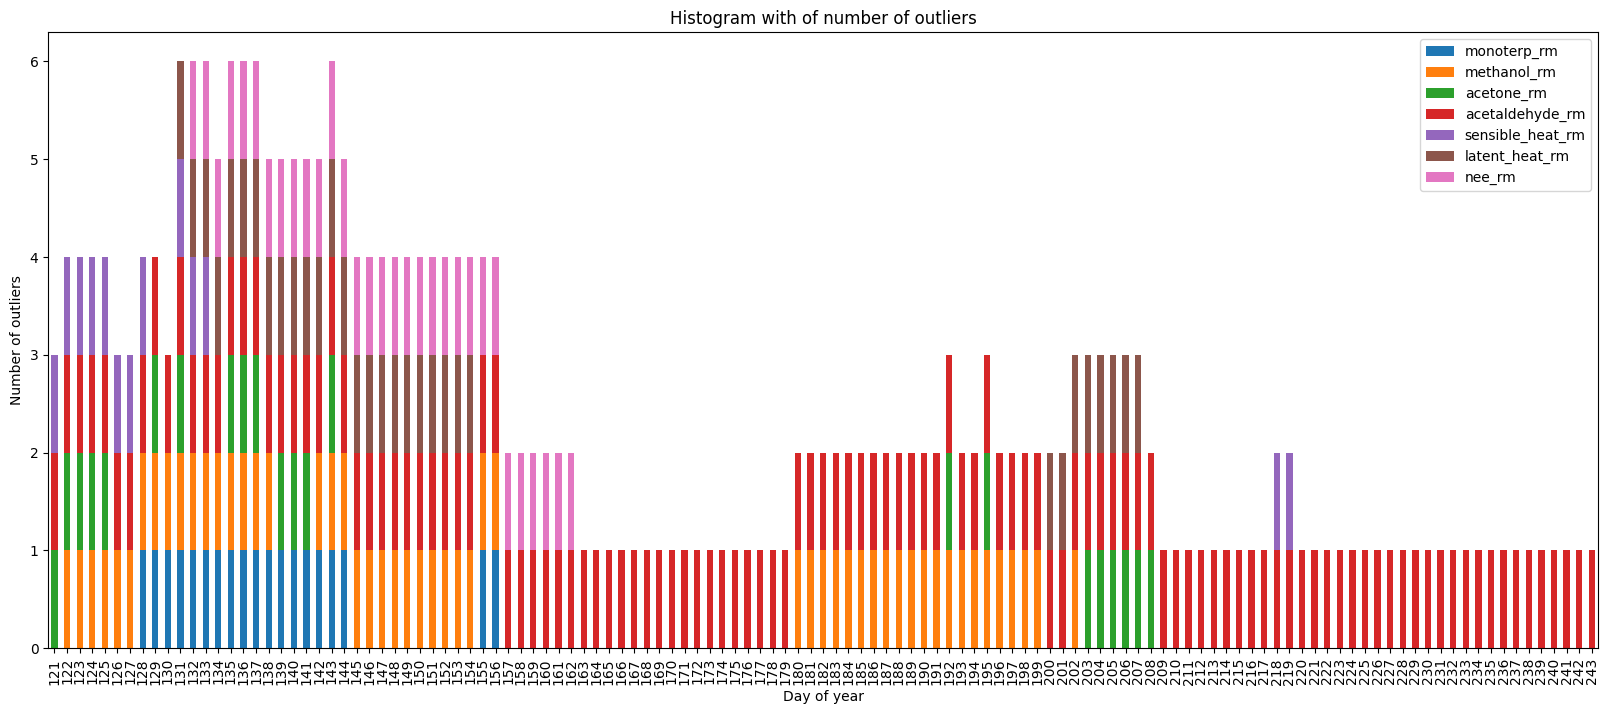

In [ ]:
daily_df_med_2022['day'] = daily_df_med_2022.index.dayofyear

df_2022 = daily_df_med_2022.drop(columns=['outliers'])

df_2022.set_index('day', inplace=True)

df_2022.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Histogram with of number of outliers')
plt.xlabel('Day of year')
plt.ylabel('Number of outliers')
plt.show()
